This is just some scratch work

In [33]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('sentiwordnet')
# nltk.download('wordnet')
from nltk.corpus import stopwords #stopwords in english 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer #stem english 
from nltk.tokenize import sent_tokenize #tokenize sentence
from nltk.tokenize import word_tokenize #tokenize word
from nltk.chunk import RegexpParser
from nltk.chunk import ne_chunk #Name Entitiy 
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier 
from itertools import cycle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
import os

In [3]:
import numpy as np
import pandas as pd
import re
import math
import string
from scipy import interp

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc

from xgboost import XGBClassifier
from gensim.models import FastText
import gensim
import os
from gensim.models.word2vec import LineSentence
from gensim.models.fasttext import FastText as FT_gensim

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\zhaox\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
seed = 42

In [6]:
raw = pd.read_csv("filtered2_camp.csv")
y = raw["character"]
X = raw["dialogue"]
y_camp = raw['camp']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=seed,stratify=y)

print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the training set: 1215
Number of rows in the test set: 406


In [8]:
add_stop = ["'ll","'re","'s", "n't", "'ve", "ca", "wo", "'m"," "]
stop_word_dict = stopwords.words("english") + add_stop

In [9]:
charac_names = ['luke','leia','han', 'threepio', 'vader']

In [10]:
name_mapping = {0:'Han', 1:'Leia', 2:'Luke', 3:'Threepio', 4:'Vader'}

# Functions for getting additional features

In [11]:
# def get_text_length(x):
#     """This function is to get the total lenth of the sentence"""
#     return np.array([len(t) for t in x]).reshape(-1, 1)

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def stemmed_words_with_stop(doc):
    return (stemmer.stem(w) for w in analyzer_with_stop(doc))

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()
analyzer_with_stop = CountVectorizer().build_analyzer()

stem_vectorizer = CountVectorizer(analyzer=stemmed_words)
stem_vectorizer_with_stop = CountVectorizer(analyzer=stemmed_words_with_stop)

vectorizer = CountVectorizer()
vectorizer_with_stop = CountVectorizer(stop_words=stop_word_dict)


def get_text_length(x):
    """This function is to get the total lenth of the sentence"""
    return np.array([len(t) for t in x]).reshape(-1, 1)

def get_questions(x):
    return np.array([t.count('?') for t in x]).reshape(-1, 1)


def get_exclaimation(x):
    return np.array([t.count('!') for t in x]).reshape(-1, 1)

def get_question_words(x):
    return np.array([(t.lower().count('who') + t.lower().count('where') + t.lower().count('what') + \
                     t.lower().count('how') + t.lower().count('when'))/len(t.split()) for t in x]).reshape(-1, 1)

# Falcon, Chewie - Han
# Anchorhead Empire Rebellion
gazetteer = ['the force', 'mind trick', 'jedi knight', 'jedi master',
           'the chosen one', 'general grievous', 'clone trooper','order 66',
           'galatic empire', 'death star', 'rebel army','millenium falcon',
           'star destroyer','battle of endor','the new republic','first order']
char_names = ['leia', 'han', 'luke', 'threepio', 'vader']
locations = ['Tatooine III', 'Lars Homestead', 'Tosche Station','Ben\'s House', 'Mos Eisley','The Cantina','Death Star',
            'Great Temple','Battle of Hoth','Echo Base','Yoda\'s House','Cloud City','Processing Vane','Jabba\'s Palace',
            "Jabba's Throne Room","Battle of Endor","Ewok Village","Death Star II","Emperor's Lair","Executor Command Tower"]

def sentence_to_list(x):
    l = list()
    for row in x:
        l.append(row.split())
    return l

def get_char_names(x):
    l = list()
    for row in x:
        l.append(sum([row.count(name)/len(row.split()) for name in char_names]))
    return np.array(l).reshape(-1, 1)

def gazette_f(x):
    l = []
    for word in gazette:
        l.append([word in row.lower() for row in x])
    return np.column_stack(l)


def get_gazetteer(x):
    l = []
    for word in gazetteer:
        l.append([row.lower().count(word)/len(row.split()) for row in x])
    return np.column_stack(l)

def get_location(x):
    l = list()
    for row in x:
        l.append(sum([row.count(loc)/len(row.split()) for loc in locations]))
    return np.array(l).reshape(-1, 1)

def get_senti_score(x):
    sentipol = []    #Sentiment polarity
    sentiscore = []  #Sentiment score
    for row in x:
        temp = word_tokenize(row.lower())
        tagged = nltk.pos_tag(temp)
        pos = 0
        neg = 0

        for word,tag in tagged:             
            ss_set = None
            if tag in ['JJ','RB','VB']:
                ss_set = list(swn.senti_synsets(word))

            if ss_set:
                pos+=ss_set[0].pos_score()
                neg+=ss_set[0].neg_score()

        if pos-neg > 0:
            sentipol.append(2)
        elif pos == neg:
            sentipol.append(1)
        else:
            sentipol.append(0)
            
        sentiscore.append(pos-neg)
        
    return np.column_stack([sentiscore])


def get_pos_pecent(x):
    count_adj_lst = []
    count_adv_lst = []
    count_pronoun_lst = []
    for row in x:
        temp = word_tokenize(row.lower())
        tagged = nltk.pos_tag(temp)

        count_adj = 0
        count_adv = 0
        count_pronoun = 0
        for word,tag in tagged: 
            if tag == 'JJ':
                count_adj += 1
            elif tag == 'RB':
                count_adv += 1
            elif tag ==' PRP':
                count_pronoun += 1
                
        count_adj_lst.append(count_adj/len(row.split()))
        count_adv_lst.append(count_adv/len(row.split()))
        count_pronoun_lst.append(count_pronoun/len(row.split()))

    return np.column_stack([count_adj_lst,count_adv_lst,count_pronoun_lst])

# BOW with other features

https://stackoverflow.com/questions/39121104/how-to-add-another-feature-length-of-text-to-current-bag-of-words-classificati
http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html

## 0-R

In [23]:
testlab0R = pd.DataFrame(y_train)
testlab0R.groupby('character').size()
# HAN         341
# LEIA        167
# LUKE        375
# THREEPIO    231
# VADER       101
d = pd.Series('LUKE', index=range(406))

#Accuracy score:  0.2953846153846154
#Precision score:  0.05907692307692308
#Recall score:  0.2
#F1 score:  0.09121140142517817
print('Accuracy score: ', format(accuracy_score(y_test, d)))
print('Precision score: ', format(precision_score(y_test, d, average = 'macro')))
print('Recall score: ', format(recall_score(y_test, d, average = 'macro')))
print('F1 score: ', format(f1_score(y_test, d, average = 'macro')))


Accuracy score:  0.3054187192118227
Precision score:  0.061083743842364535
Recall score:  0.2
F1 score:  0.09358490566037736


C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## LR

In [28]:
classifier = Pipeline([
    ('features', FeatureUnion([
#         ('text', Pipeline([
#             ('vectorizer', vectorizer),
#             ('tfidf', TfidfTransformer()),
#         ])),
        ('text 2-gram', Pipeline([
            ('vectorizer', CountVectorizer(ngram_range=(1,2))),
#             ('tfidf', TfidfTransformer()),
        ])),
        ('count', FunctionTransformer(get_text_length, validate=False)),
        ('get_questions', FunctionTransformer(get_questions, validate=False)),
        ('get_exclaimation', FunctionTransformer(get_exclaimation, validate=False)),
        ('get_question_words', FunctionTransformer(get_question_words, validate=False)),
        ('get_char_names', FunctionTransformer(get_char_names, validate=False)),
        ('get_gazetteer', FunctionTransformer(get_gazetteer, validate=False)),
        ('get_senti_score', FunctionTransformer(get_senti_score, validate=False)), 
#         ('get_location', FunctionTransformer(get_location, validate=False)), 
#         ('get_pos_pecent', FunctionTransformer(get_pos_pecent, validate=False)), 
    ])),
    
#     ('mutual_info', SelectKBest(mutual_info_classif, k=5000)),
    
#     ('mutual_info', SelectKBest(chi2, k=1000)),
#     ('scale', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(multi_class = "ovr", solver="newton-cg"))])
classifier.fit(X_train, y_train)
predictions_lr = classifier.predict(X_test)
print(len(classifier.steps[-1][1].coef_[0]))

8791


In [268]:
def show_most_informative_features(vectorizer, clf, n=10, index = 0):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[index], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("Most Informative Features for Class:", name_mapping[index])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("coef:{:.5f}\t word:{}\t\tcoef:{:.5f}\tword:{}".format(coef_1, str(fn_1), coef_2, str(fn_2)))

In [203]:
vec = CountVectorizer(ngram_range=(1,2))
vec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [269]:
for i in range(n_classes):
    show_most_informative_features(vec, classifier.steps[2][1], index=i)

Most Informative Features for Class: Han
coef:-0.78018	 word:no	coef:0.63872	word:chewie
coef:-0.66169	 word:artoo	coef:0.57690	word:where
coef:-0.58007	 word:princess leia	coef:0.54570	word:see
coef:-0.51655	 word:oh	coef:0.52264	word:look
coef:-0.48136	 word:are you	coef:0.42731	word:luke
coef:-0.40126	 word:han	coef:0.39335	word:better
coef:-0.40072	 word:help	coef:0.37256	word:sorry
coef:-0.39338	 word:threepio	coef:0.36763	word:princess
coef:-0.36663	 word:right	coef:0.36743	word:you all
coef:-0.35843	 word:never	coef:0.33859	word:hyperdrive
Most Informative Features for Class: Leia
coef:-0.59884	 word:luke	coef:0.73436	word:oh
coef:-0.53749	 word:artoo	coef:0.57580	word:luke luke
coef:-0.47803	 word:good	coef:0.48767	word:can
coef:-0.47138	 word:see	coef:0.40013	word:that right
coef:-0.46814	 word:yeah	coef:0.36023	word:yes
coef:-0.43491	 word:where	coef:0.34798	word:afraid
coef:-0.42491	 word:right	coef:0.28193	word:okay easy
coef:-0.39242	 word:look	coef:0.25588	word:asteroids


In [29]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions_lr)))
print('Precision score: ', format(precision_score(y_test, predictions_lr, average = 'macro')))
print('Recall score: ', format(recall_score(y_test, predictions_lr, average = 'macro')))
print('F1 score: ', format(f1_score(y_test, predictions_lr, average = 'macro')))

Accuracy score:  0.4827586206896552
Precision score:  0.5109944706456335
Recall score:  0.4566830259379163
F1 score:  0.4752295769128624


In [172]:
### raw BOW
print('Accuracy score: ', format(accuracy_score(y_test, predictions_lr)))
print('Precision score: ', format(precision_score(y_test, predictions_lr, average = 'macro')))
print('Recall score: ', format(recall_score(y_test, predictions_lr, average = 'macro')))
print('F1 score: ', format(f1_score(y_test, predictions_lr, average = 'macro')))

Accuracy score:  0.4827586206896552
Precision score:  0.5086427482939111
Recall score:  0.4566830259379163
F1 score:  0.47431411475602425


[Text(0,0.5,'han'),
 Text(0,1.5,'leia'),
 Text(0,2.5,'luke'),
 Text(0,3.5,'threepio'),
 Text(0,4.5,'vader')]

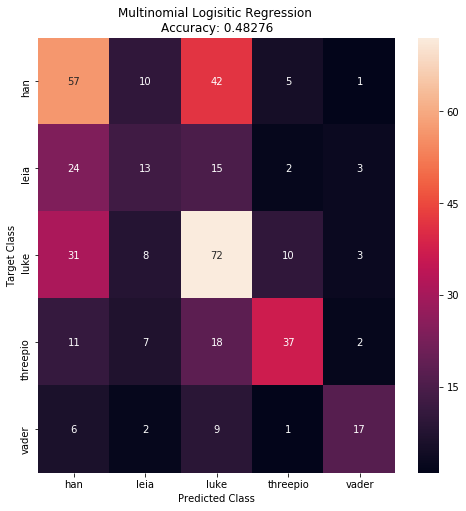

In [41]:
#Create confusion matrix and heatmap
confusion_lr = confusion_matrix(y_test, predictions_lr)
df_confusion = pd.DataFrame(confusion_lr)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(sns.heatmap(df_confusion, annot=True))
plt.title('Multinomial Logisitic Regression \nAccuracy: {0:.5f}'.format(accuracy_score(y_test, predictions_lr)))
plt.ylabel('Target Class')
plt.xlabel('Predicted Class')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xticklabels(sorted(char_names))
ax.set_yticklabels(sorted(char_names))


## AUC

In [12]:
y_auc = label_binarize(y, classes=['HAN','LEIA','LUKE','THREEPIO','VADER'])
n_classes = y_auc.shape[1]

X_train_auc, X_test_auc, y_train_auc, y_test_auc = train_test_split(X, y_auc, random_state = seed)

classifier = OneVsRestClassifier(LogisticRegression(multi_class = "multinomial",solver= "newton-cg", random_state = seed ))


In [16]:
classifier = Pipeline([
    ('features', FeatureUnion([
#         ('text', Pipeline([
#             ('vectorizer', vectorizer),
#             ('tfidf', TfidfTransformer()),
#         ])),
        ('text 2-gram', Pipeline([
            ('vectorizer', CountVectorizer(ngram_range=(1,2))),
#             ('tfidf', TfidfTransformer()),
        ])),
        ('count', FunctionTransformer(get_text_length, validate=False)),
        ('get_questions', FunctionTransformer(get_questions, validate=False)),
        ('get_exclaimation', FunctionTransformer(get_exclaimation, validate=False)),
        ('get_question_words', FunctionTransformer(get_question_words, validate=False)),
        ('get_char_names', FunctionTransformer(get_char_names, validate=False)),
        ('get_gazetteer', FunctionTransformer(get_gazetteer, validate=False)),
        ('get_senti_score', FunctionTransformer(get_senti_score, validate=False)), 
#         ('get_location', FunctionTransformer(get_location, validate=False)), 
#         ('get_pos_pecent', FunctionTransformer(get_pos_pecent, validate=False)), 
    ])),
    
#     ('mutual_info', SelectKBest(mutual_info_classif, k=5000)),
    
#     ('mutual_info', SelectKBest(chi2, k=1000)),
    ('clf', LogisticRegression(multi_class = "ovr"))])

classifier_one = OneVsRestClassifier(classifier)
classifier_one.fit(X_train_auc, y_train_auc)

OneVsRestClassifier(estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text 2-gram', Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, m...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          n_jobs=1)

In [17]:
y_score = classifier_one.decision_function(X_test_auc)

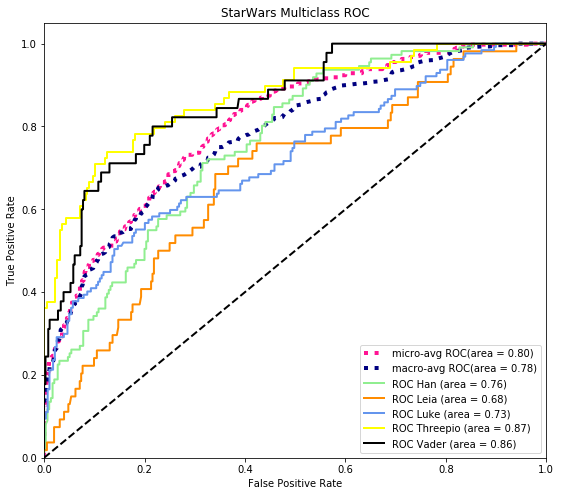

In [18]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_auc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_auc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(9,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-avg ROC(area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-avg ROC(area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

name = ""
colors = cycle(['lightgreen', 'darkorange', 'cornflowerblue', 'yellow', 'black'])
for i, color in zip(range(n_classes), colors):
    name = name_mapping[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC {0} (area = {1:0.2f})'
             ''.format(name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('StarWars Multiclass ROC')
plt.legend(loc="lower right")
plt.show()

## Naive bayes

In [155]:
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', stem_vectorizer),
#             ('tfidf', TfidfTransformer()),
        ])),
#         ('length', Pipeline([
#             ('count', FunctionTransformer(get_text_length, validate=False)),
#         ])),
#         ('questions', Pipeline([
#             ('q', FunctionTransformer(get_questions, validate=False)),
#         ])),
#         ('exclaimation', Pipeline([
#             ('e', FunctionTransformer(get_exclaimation, validate=False)),
#         ])),
#         ('get_question_words', Pipeline([
#             ('g', FunctionTransformer(get_question_words, validate=False)),
#         ])),
#         ('get_charc_names', Pipeline([
#             ('n', FunctionTransformer(get_charc_names, validate=False)),
#         ]))
    ])),
    ('clf', MultinomialNB())])
classifier.fit(X_train, y_train)
predictions_nb = classifier.predict(X_test)

In [156]:
print(len(classifier.steps[1][1].coef_[0]))

1339


In [157]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions_nb)))
print('Precision score: ', format(precision_score(y_test, predictions_nb, average = 'macro')))
print('Recall score: ', format(recall_score(y_test, predictions_nb, average = 'macro')))
print('F1 score: ', format(f1_score(y_test, predictions_nb, average = 'macro')))

Accuracy score:  0.5049261083743842
Precision score:  0.5263517737686536
Recall score:  0.464348200818789
F1 score:  0.4747011129943203


## RF

In [312]:
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', stem_vectorizer),
            ('tfidf', TfidfTransformer()),
        ])),
#         ('length', Pipeline([
#             ('count', FunctionTransformer(get_text_length, validate=False)),
#         ])),
#         ('questions', Pipeline([
#             ('q', FunctionTransformer(get_questions, validate=False)),
#         ])),
#         ('exclaimation', Pipeline([
#             ('e', FunctionTransformer(get_exclaimation, validate=False)),
#         ])),
#         ('get_question_words', Pipeline([
#             ('g', FunctionTransformer(get_question_words, validate=False)),
#         ])),
        ('get_char_names', Pipeline([
            ('n', FunctionTransformer(get_char_names, validate=False)),
        ])),
#         ('get_gazetteer', Pipeline([
#             ('get_gazetteer', FunctionTransformer(get_gazetteer, validate=False)),
#         ])),
#         ('get_senti_score', Pipeline([
#             ('g', FunctionTransformer(get_senti_score, validate=False)),
#         ])),
    ])),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1))])
classifier.fit(X_train, y_train)
predictions_rf = classifier.predict(X_test)

In [313]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions_rf)))
print('Precision score: ', format(precision_score(y_test, predictions_rf, average = 'macro')))
print('Recall score: ', format(recall_score(y_test, predictions_rf, average = 'macro')))
print('F1 score: ', format(f1_score(y_test, predictions_rf, average = 'macro')))

Accuracy score:  0.47783251231527096
Precision score:  0.47815456496137154
Recall score:  0.460102001687246
F1 score:  0.46457355343377704


In [307]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions_rf)))
print('Precision score: ', format(precision_score(y_test, predictions_rf, average = 'macro')))
print('Recall score: ', format(recall_score(y_test, predictions_rf, average = 'macro')))
print('F1 score: ', format(f1_score(y_test, predictions_rf, average = 'macro')))

Accuracy score:  0.458128078817734
Precision score:  0.5189098932883616
Recall score:  0.4248302710914874
F1 score:  0.4490034618192217


## XGBoost

In [76]:
classifier = Pipeline([
    ('features', FeatureUnion([
#         ('text', Pipeline([
#             ('vectorizer', vectorizer),
#             ('tfidf', TfidfTransformer()),
#         ])),
        ('text 2-gram', Pipeline([
            ('vectorizer', CountVectorizer(ngram_range=(1,2))),
            ('tfidf', TfidfTransformer()),
        ])),
#         ('count', FunctionTransformer(get_text_length, validate=False)),
        ('q', FunctionTransformer(get_questions, validate=False)),
        ('e', FunctionTransformer(get_exclaimation, validate=False)),
        ('g', FunctionTransformer(get_question_words, validate=False)),
        ('n', FunctionTransformer(get_char_names, validate=False)),
#         ('get_gazetteer', FunctionTransformer(get_gazetteer, validate=False)),
#         ('get_senti_score', FunctionTransformer(get_senti_score, validate=False)),           
#     ('mutual_info', SelectKBest(mutual_info_classif, k=5000)), 
#     ('mutual_info', SelectKBest(chi2, k=1000)),
    ])),
    ('clf', XGBClassifier(n_estimators=1000,random_state=seed))])
classifier.fit(X_train, y_train)
predictions_xgb = classifier.predict(X_test)

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [77]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions_xgb)))
print('Precision score: ', format(precision_score(y_test, predictions_xgb, average = 'macro')))
print('Recall score: ', format(recall_score(y_test, predictions_xgb, average = 'macro')))
print('F1 score: ', format(f1_score(y_test, predictions_xgb, average = 'macro')))

Accuracy score:  0.4236453201970443
Precision score:  0.4603190830334262
Recall score:  0.4030403920038525
F1 score:  0.4197090428345504


In [163]:
predictions_svm = classifier.predict(X_test)
print('Accuracy score: ', format(accuracy_score(y_test, predictions_svm)))
print('Precision score: ', format(precision_score(y_test, predictions_svm, average = 'macro')))
print('Recall score: ', format(recall_score(y_test, predictions_svm, average = 'macro')))
print('F1 score: ', format(f1_score(y_test, predictions_svm, average = 'macro')))

Accuracy score:  0.4827586206896552
Precision score:  0.5118065938278704
Recall score:  0.4330964615311574
F1 score:  0.43689384528316655


C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# fasttext

https://fasttext.cc/docs/en/supervised-tutorial.html

https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c

https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/FastText_Tutorial.ipynb

http://ai.intelligentonlinetools.com/ml/fasttext-word-embeddings-text-classification-python-mlp/

In [80]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('./pretrained/wiki-news-300d-1M.vec')

print (model.most_similar('desk'))

[('desks', 0.7923153638839722), ('Desk', 0.6869950890541077), ('desk.', 0.6602819561958313), ('desk-', 0.6187258958816528), ('credenza', 0.595531702041626), ('roll-top', 0.5875717401504517), ('rolltop', 0.5837830305099487), ('bookshelf', 0.5758029818534851), ('Desks', 0.5755287408828735), ('sofa', 0.5617446899414062)]


In [164]:
X_new = X.apply(str.split)

In [165]:
model_film = FastText(X_new, size=200)

In [166]:
print (model_film['Hello Sir!'])

[ 0.18945178 -0.10875528  0.07031621  0.0363139  -0.09122859 -0.07991193
 -0.05714969 -0.0624925  -0.09999298  0.15876235  0.05038403  0.05869505
  0.02520633 -0.12194363  0.0338432   0.07961266 -0.03158679 -0.06874112
  0.15780747 -0.01477579 -0.07078864 -0.04308448  0.0304283   0.02980639
 -0.02642369  0.01037166 -0.06771374 -0.04425424  0.09786908 -0.00817189
 -0.02048106 -0.02561992  0.02241291 -0.00725531  0.12413937 -0.08870913
 -0.060411   -0.08558942 -0.11058029  0.09972127 -0.1403695   0.06240801
 -0.17575118  0.10926148  0.15739037  0.13806279  0.02938094  0.02050609
 -0.03481352  0.10561359 -0.08532856 -0.06313713 -0.12478014  0.00459811
 -0.16219774 -0.09041394  0.0317265  -0.02027912 -0.00108909 -0.12976623
  0.04285639  0.13780399 -0.00918725 -0.18472242  0.0386099  -0.03203791
 -0.1797121  -0.14448127 -0.04208865 -0.02331364 -0.09447408 -0.00559809
 -0.05729965  0.07062617  0.03486917  0.04821441  0.01467768 -0.14478835
  0.10307286  0.2057809   0.06074817  0.1187161   0

C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [167]:
def sent_vectorizer(sent, this_model):
    
    all_list = []
    for sentence in sent:
        sent_vec =[]
        numw = 0
        for w in sentence:
            if w in this_model:
                if numw == 0:
                    sent_vec = this_model[w]
                else:
                    sent_vec = np.add(sent_vec, this_model[w])
                numw+=1
            else:
                continue
        if numw:
            all_list.append((np.asarray(sent_vec)/numw))
        else:
            all_list.append(np.zeros(this_model.vector_size))
    
    return np.asarray(all_list)

In [168]:
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', CountVectorizer(stop_words=stop_word_dict)),
            ('tfidf', TfidfTransformer()),
        ])),
        ('word2vec', Pipeline([
            ('to_list', FunctionTransformer(sentence_to_list, validate=False)),
            ('w', FunctionTransformer(sent_vectorizer, validate=False, kw_args={'this_model': model})),
        ])),
        ('questions', Pipeline([
            ('q', FunctionTransformer(get_questions, validate=False)),
        ])),
        ('exclaimation', Pipeline([
            ('e', FunctionTransformer(get_exclaimation, validate=False)),
        ])),
#         ('get_question_words', Pipeline([
#             ('g', FunctionTransformer(get_question_words, validate=False)),
#         ])),
#         ('get_charc_names', Pipeline([
#             ('n', FunctionTransformer(get_charc_names, validate=False)),
#         ]))
    ])),
    ('clf', RandomForestClassifier(n_estimators=500))])
classifier.fit(X_train, y_train)
#predictions_xgb = classifier.predict(X_test)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [169]:
# check if the number of features is correct
print(len(classifier.steps[1][1].feature_importances_))

1892


In [170]:
predictions_rf = classifier.predict(X_test)

In [171]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions_rf)))
print('Precision score: ', format(precision_score(y_test, predictions_rf, average = 'macro')))
print('Recall score: ', format(recall_score(y_test, predictions_rf, average = 'macro')))
print('F1 score: ', format(f1_score(y_test, predictions_rf, average = 'macro')))

Accuracy score:  0.3891625615763547
Precision score:  0.41667131566713156
Recall score:  0.29892206165386626
F1 score:  0.2848730890254875


# Camp Classification

In [172]:
X_train_camp, X_test_camp, y_train_camp, y_test_camp = train_test_split(X, 
                                                    y_camp, 
                                                    random_state=1)

print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the training set: 1215
Number of rows in the test set: 406


## 0-R

In [173]:
testlab0R = pd.DataFrame(y_train_camp)
testlab0R.groupby('camp').size()
#HAN 96,LEIA 48,LUKE 92,THREEPIO 59,VADER 30 -- so go by HAN
d = pd.Series('Rebellion', index=range(406))

#Accuracy score:  0.2953846153846154
#Precision score:  0.05907692307692308
#Recall score:  0.2
#F1 score:  0.09121140142517817
print('Accuracy score: ', format(accuracy_score(y_test_camp, d)))
print('Precision score: ', format(precision_score(y_test_camp, d, average = 'macro')))
print('Recall score: ', format(recall_score(y_test_camp, d, average = 'macro')))
print('F1 score: ', format(f1_score(y_test_camp, d, average = 'macro')))


Accuracy score:  0.9039408866995073
Precision score:  0.45197044334975367
Recall score:  0.5
F1 score:  0.47477360931435963


C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## BOW

In [387]:
classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', vectorizer),
#             ('tfidf', TfidfTransformer()),
        ])),
        ('length', Pipeline([
            ('count', FunctionTransformer(get_text_length, validate=False)),
        ])),
        ('questions', Pipeline([
            ('q', FunctionTransformer(get_questions, validate=False)),
        ])),
        ('exclaimation', Pipeline([
            ('e', FunctionTransformer(get_exclaimation, validate=False)),
        ])),
        ('get_question_words', Pipeline([
            ('g', FunctionTransformer(get_question_words, validate=False)),
        ])),
        ('get_char_names', Pipeline([
            ('n', FunctionTransformer(get_char_names, validate=False)),
        ])),
#         ('get_gazetteer', Pipeline([
#             ('get_gazetteer', FunctionTransformer(get_gazetteer, validate=False)),
#         ])),
#         ('get_senti_score', Pipeline([
#             ('g', FunctionTransformer(get_senti_score, validate=False)),
#         ])),
    ])),
    ('clf', LogisticRegression(multi_class = "ovr"))])
classifier.fit(X_train_camp, y_train_camp)
predictions_lr = classifier.predict(X_test)
print(len(classifier.steps[1][1].coef_[0]))

1728


In [386]:
print('Accuracy score: ', format(accuracy_score(y_test_camp, predictions_lr)))
print('Precision score: ', format(precision_score(y_test_camp, predictions_lr, average = 'macro')))
print('Recall score: ', format(recall_score(y_test_camp, predictions_lr, average = 'macro')))
print('F1 score: ', format(f1_score(y_test_camp, predictions_lr, average = 'macro')))

Accuracy score:  0.9285714285714286
Precision score:  0.8729166666666667
Recall score:  0.6625794732061762
F1 score:  0.717209078899964


In [366]:
# raw BOW
print('Accuracy score: ', format(accuracy_score(y_test_camp, predictions_lr)))
print('Precision score: ', format(precision_score(y_test_camp, predictions_lr, average = 'macro')))
print('Recall score: ', format(recall_score(y_test_camp, predictions_lr, average = 'macro')))
print('F1 score: ', format(f1_score(y_test_camp, predictions_lr, average = 'macro')))

Accuracy score:  0.9211822660098522
Precision score:  0.8477197103151302
Recall score:  0.6241179347446377
F1 score:  0.671255060728745


[Text(0,0.5,'Empire'), Text(0,1.5,'Rebellion')]

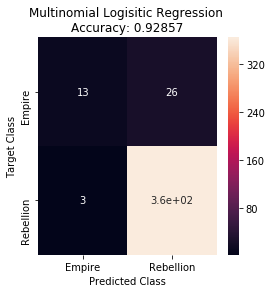

In [390]:
#Create confusion matrix and heatmap
confusion_lr = confusion_matrix(y_test_camp, predictions_lr)
df_confusion = pd.DataFrame(confusion_lr)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(sns.heatmap(df_confusion, annot=True))
plt.title('Multinomial Logisitic Regression \nAccuracy: {0:.5f}'.format(accuracy_score(y_test_camp, predictions_lr)))
plt.ylabel('Target Class')
plt.xlabel('Predicted Class')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xticklabels(['Empire', 'Rebellion'])
ax.set_yticklabels(['Empire', 'Rebellion'])

## Word2Vec

In [129]:
classifier = Pipeline([
    ('features', FeatureUnion([
#         ('text', Pipeline([
#             ('vectorizer', CountVectorizer(stop_words=stop_word_dict)),
#             ('tfidf', TfidfTransformer()),
#         ])),
        ('word2vec', Pipeline([
            ('to_list', FunctionTransformer(sentence_to_list, validate=False)),
            ('w', FunctionTransformer(sent_vectorizer, validate=False, kw_args={'this_model': model_film})),
        ])),
        ('questions', Pipeline([
            ('q', FunctionTransformer(get_questions, validate=False)),
        ])),
        ('exclaimation', Pipeline([
            ('e', FunctionTransformer(get_exclaimation, validate=False)),
        ])),
        ('get_question_words', Pipeline([
            ('g', FunctionTransformer(get_question_words, validate=False)),
        ])),
#         ('get_charc_names', Pipeline([
#             ('n', FunctionTransformer(get_charc_names, validate=False)),
#         ]))
    ])),
    ('clf', RandomForestClassifier(n_estimators=1500, n_jobs=4))])
classifier.fit(X_train_camp, y_train_camp)


C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('word2vec', Pipeline(memory=None,
     steps=[('to_list', FunctionTransformer(accept_sparse=False,
          func=<function sentence_to_list at 0x000001C82C1E0950>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
     ...n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [130]:
predictions_rf = classifier.predict(X_test_camp)

C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\zhaox\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [128]:
print('Accuracy score: ', format(accuracy_score(y_test_camp, predictions_rf)))
print('Precision score: ', format(precision_score(y_test_camp, predictions_rf, average = 'macro')))
print('Recall score: ', format(recall_score(y_test_camp, predictions_rf, average = 'macro')))
print('F1 score: ', format(f1_score(y_test_camp, predictions_rf, average = 'macro')))

Accuracy score:  0.9064039408866995
Precision score:  0.7349566190876015
Recall score:  0.5586529728219101
F1 score:  0.5792975567190227


# LSTM and CNN

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b
https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-visualize-word-embeddings-part-2-ca137a42a97d
https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa